### Uso de unsupervised learning para la identificación de Perfiles Educativos y Sociales en el ámbito de la Educación Superior

In [16]:
# Carga de los datos agregados
import pandas as pd
import numpy as np


df_matriculas = pd.read_excel("base_matricula_datosabiertos.xlsx", engine='openpyxl')



In [17]:
# Desagregación del set de datos
# Se convierte la columna 'tot' a enteros
df_matriculas['tot'] = df_matriculas['tot'].astype(int)



C:\Users\luis.baca\AppData\Local\Temp\ipykernel_25344\2008887466.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_matriculas, x=column, order=df_matriculas[column].value_counts().index, palette="coolwarm")
C:\Users\luis.baca\AppData\Local\Temp\ipykernel_25344\2008887466.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_matriculas, x=column, order=df_matriculas[column].value_counts().index, palette="coolwarm")
C:\Users\luis.baca\AppData\Local\Temp\ipykernel_25344\2008887466.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  s

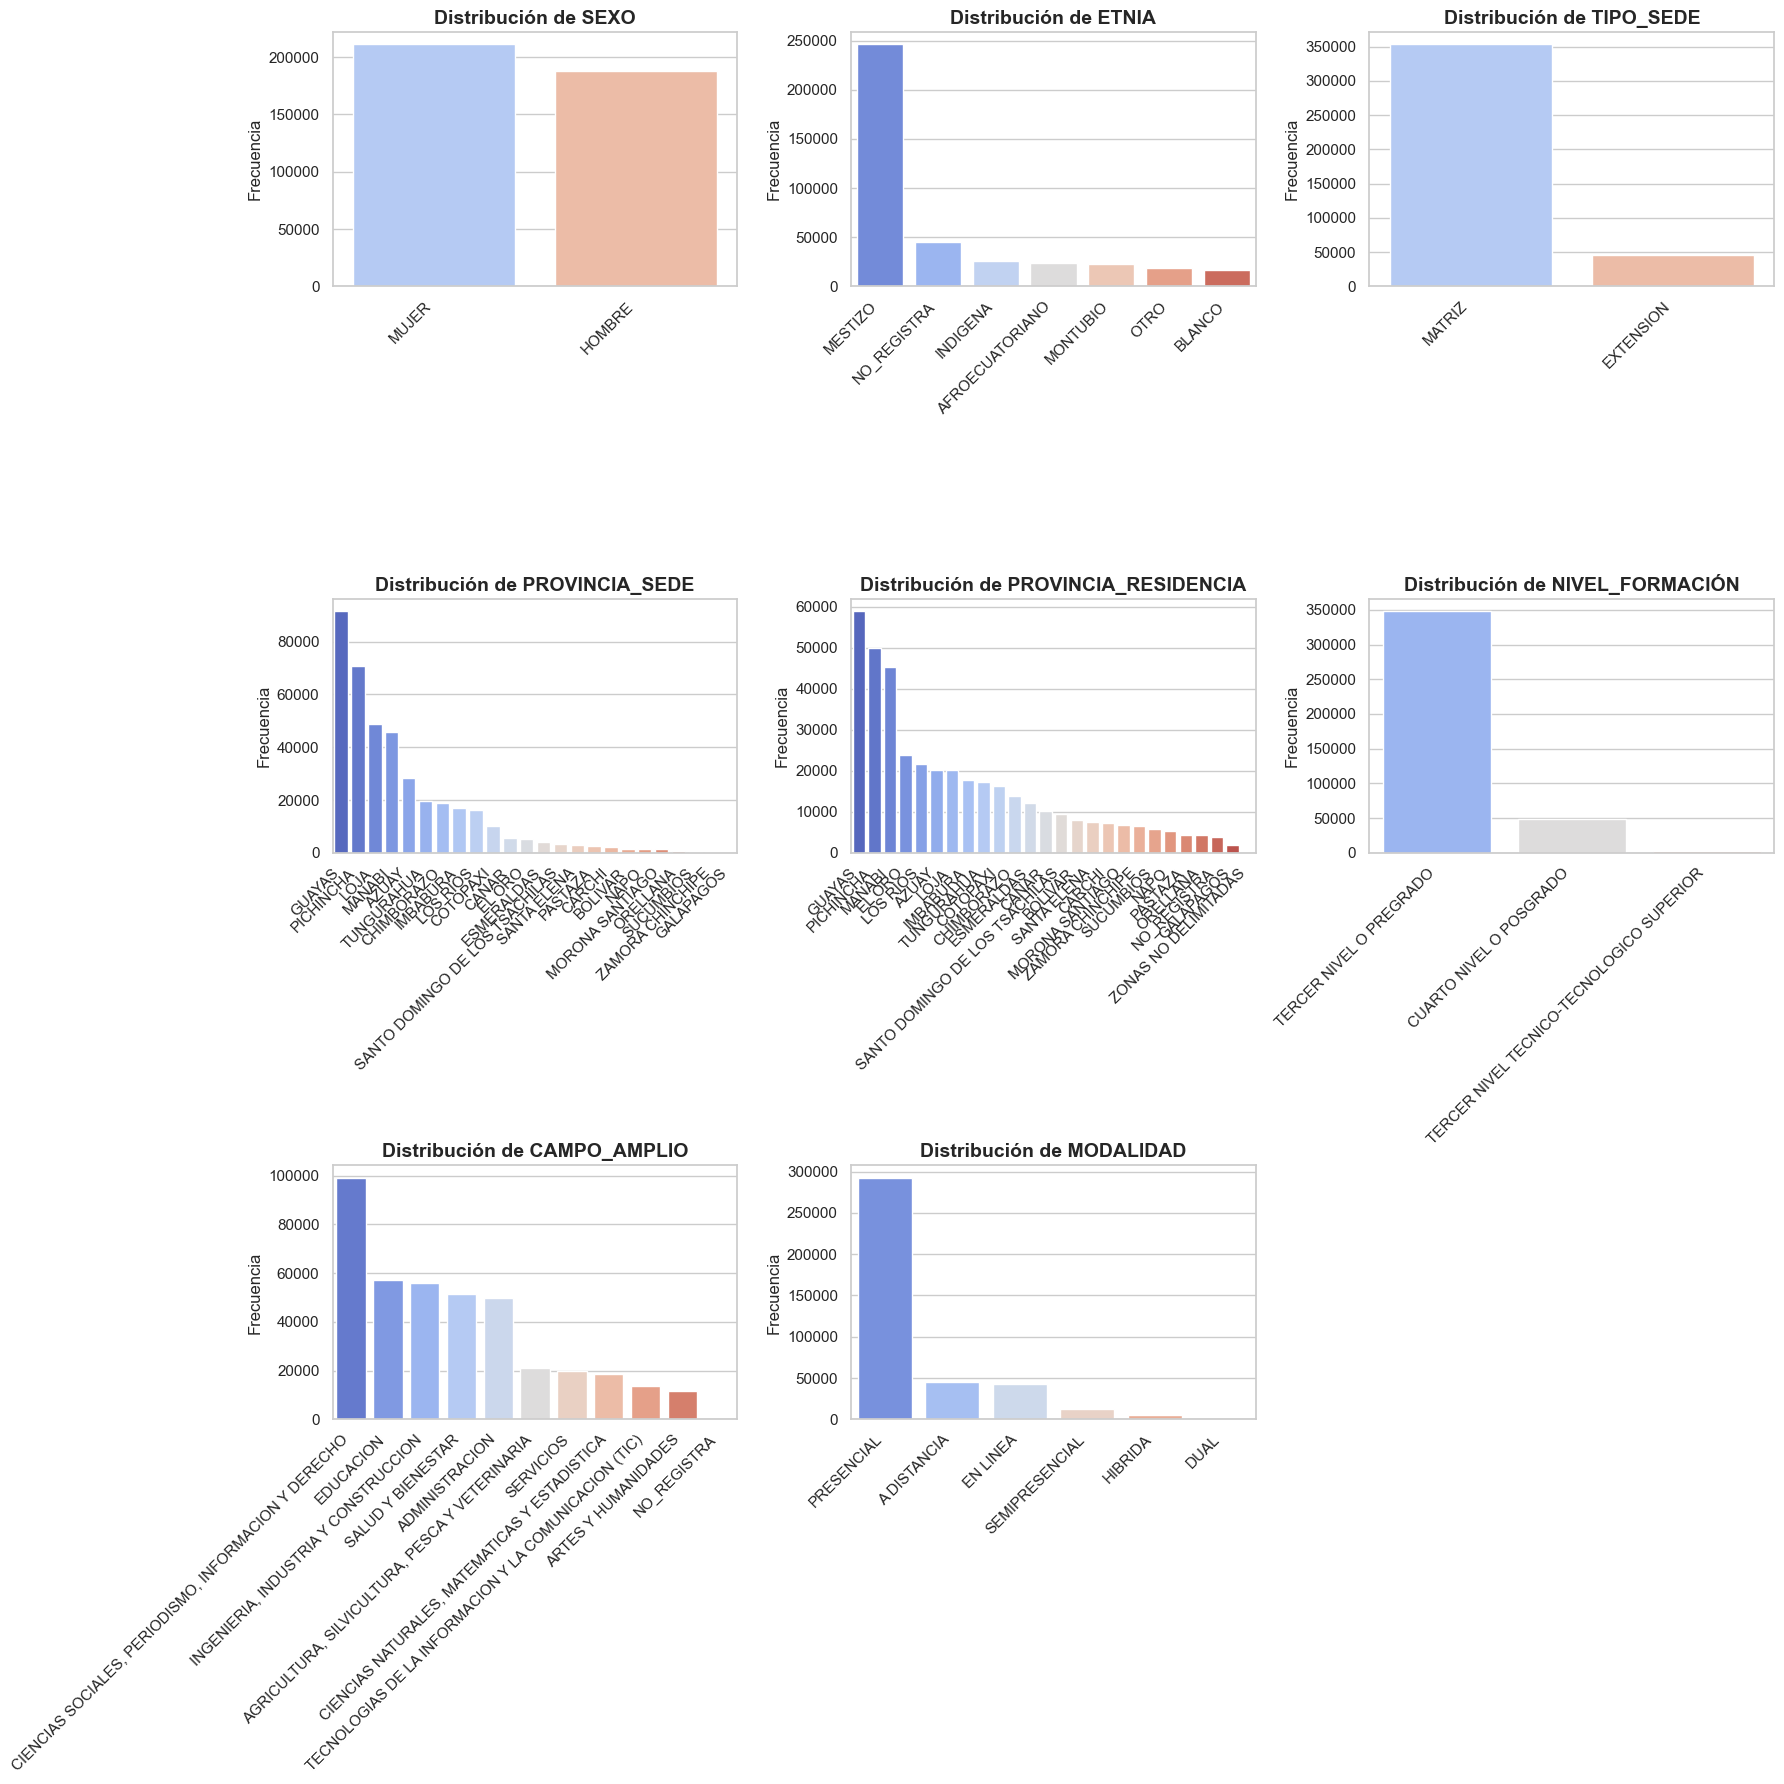

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Establecemos estilo y paleta para hacer el gráfico más profesional
sns.set(style="whitegrid", palette="coolwarm")

# Variables principales para graficar (ajusta según tu dataset)
categorical_columns = ['SEXO', 'ETNIA', 'TIPO_SEDE', 'PROVINCIA_SEDE', 'PROVINCIA_RESIDENCIA', 'NIVEL_FORMACIÓN', 'CAMPO_AMPLIO', 'MODALIDAD']
numerical_columns = []  # Si tienes variables numéricas relevantes, puedes agregarlas aquí

# Tamaño total del gráfico
plt.figure(figsize=(18, 18))

# Creamos subgráficos (2 filas, 3 columnas para esta configuración)
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(3, 3, i)  # 2 filas, 3 columnas, posición i
    sns.countplot(data=df_matriculas, x=column, order=df_matriculas[column].value_counts().index, palette="coolwarm")
    plt.title(f"Distribución de {column}", fontsize=14, weight='bold')
    plt.xlabel('')
    plt.ylabel('Frecuencia', fontsize=12)
    plt.xticks(rotation=45, ha="right")

# Si hay columnas numéricas para añadir, las integramos aquí
for i, column in enumerate(numerical_columns, len(categorical_columns) + 1):
    plt.subplot(2, 3, i)  # Continuamos añadiendo subgráficos
    sns.histplot(df_matriculas[column], kde=True, color='skyblue')
    plt.title(f"Distribución de {column}", fontsize=14, weight='bold')
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)

# Ajustamos la disposición de los subgráficos para evitar superposición
plt.tight_layout()

# Mostramos el gráfico como un póster
plt.show()


In [19]:
#Realizar one hot encoding a los datoa

from sklearn.preprocessing import OneHotEncoder
from scipy import sparse

# Configurar OneHotEncoder con salida esparsa
encoder = OneHotEncoder(sparse_output=True)

# Codificar las columnas categóricas
df_encoded_sparse = encoder.fit_transform(df_matriculas[categorical_columns])

# Convertir a formato dataframe esparso
df_encoded_sparse = sparse.hstack([df_matriculas.select_dtypes(include=[np.number]), df_encoded_sparse])

# Luego puedes alimentar esta matriz esparsa a tu modelo de clustering



In [20]:
df_encoded_sparse

<399176x84 sparse matrix of type '<class 'numpy.float64'>'
	with 4390936 stored elements in COOrdinate format>

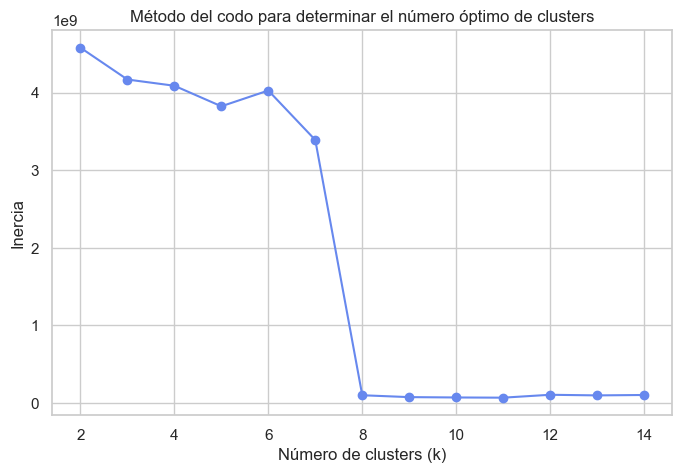

In [21]:
#Determinar el numero de clusters

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# Definir el rango de clusters que quieres probar
k_values = range(2, 15)
inertia_values = []

# Ejecutar MiniBatchKMeans para cada valor de k
for k in k_values:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    kmeans.fit(df_encoded_sparse)
    
    # Guardar la inercia (distancia dentro de clusters)
    inertia_values.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o')
plt.title('Método del codo para determinar el número óptimo de clusters')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()



In [22]:
##Uso silhouette_score para determinar si el número de clusters escogido es correcto 

best_k = 5  # Suponiendo que decides usar 5 clusters
kmeans = MiniBatchKMeans(n_clusters=best_k, random_state=42, batch_size=10000)
kmeans.fit(df_encoded_sparse)

# Calcular el Silhouette Score (entre -1 y 1, donde 1 es el mejor)
silhouette_avg = silhouette_score(df_encoded_sparse, kmeans.labels_)
print(f"Silhouette Score para {best_k} clusters: {silhouette_avg}")


Silhouette Score para 5 clusters: 0.441820269588303


In [23]:
# Obtener las etiquetas asignadas a cada muestra
labels = kmeans.labels_

# Crear un DataFrame para contar los registros por cluster
cluster_counts = pd.DataFrame({'Cluster': labels}).value_counts().sort_index()

# Imprimir la cantidad de registros en cada cluster
print(cluster_counts)

Cluster
0            1079
1          152034
2          158087
3           84383
4            3593
Name: count, dtype: int64


In [24]:
# Convertir la matriz dispersa en un DataFrame de Pandas
df_dense = pd.DataFrame(df_encoded_sparse.toarray())

# Asignar las etiquetas de los clusters
df_dense['Cluster'] = labels  # Asegúrate de que 'labels' son las etiquetas correctas

# Calcular el promedio de las características para cada cluster
cluster_profiles = df_dense.groupby('Cluster').mean()

# Mostrar el resultado
cluster_profiles


,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
Cluster,,,,,,,,,,,,,,,,,,,,,
0,2021.970343,3026.571826,3.795181,0.441149,0.558851,0.000000,0.003707,0.000000,0.993513,0.000000,...,0.000000,0.115848,0.000000,0.009268,0.000000,0.000000,0.778499,0.060241,0.161260,0.000000
1,2021.048358,1027.384684,2.834991,0.471723,0.528277,0.047713,0.044569,0.073017,0.630497,0.042313,...,0.000197,0.123545,0.038978,0.031480,0.233468,0.000362,0.108752,0.013398,0.625867,0.018154
2,2021.033792,1009.475921,4.314409,0.461815,0.538185,0.074750,0.042793,0.053856,0.567985,0.089021,...,0.000127,0.151448,0.049321,0.037473,0.023740,0.000645,0.049941,0.000633,0.913042,0.012000
3,2021.032139,1054.520887,4.474029,0.489174,0.510826,0.058140,0.038752,0.078073,0.668417,0.022315,...,0.000000,0.097614,0.073996,0.033384,0.063745,0.003875,0.207447,0.039830,0.591458,0.093644
4,2021.040635,1023.493738,207.597272,0.440301,0.559699,0.010854,0.000000,0.000000,0.830504,0.000000,...,0.000000,0.162260,0.030058,0.042861,0.049262,0.003062,0.045923,0.005566,0.883663,0.012524
